# Plotting HEALPix Data with XDGGS and Lonboard

## Authors & Contributors
### Authors
- Tina Odaka, Ifremer (France), [@tinaok](https://github.com/tinaok)

## Purpose
In this notebook, we will demonstrate several examples of plotting HEALPix data.  
This notebook is prepared for a poster presentation at the 3rd Destination Earth User eXchange, held from October 15 - October 16, 2024, in Darmstadt. You can find more information about the event here: [3rd Destination Earth User eXchange](https://destination-earth.eu/event/3rd-destination-earth-user-exchange/).

Link to the poster on Zenodo: [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.13934967.svg)](https://doi.org/10.5281/zenodo.13934967)

## Setup

To run this notebook, you need to install XDGGS along with Lonboard. You can find the repository here: [XDGGS GitHub Repository](https://github.com/xarray-contrib/xdggs.git).

To install the necessary dependencies, use the following command:

```bash
pip install "xdggs[explore] @ git+https://github.com/xarray-contrib/xdggs.git"```

This command installs the XDGGS package directly from its GitHub repository. The `@` symbol indicates that the package is being installed from a specific URL, in this case, GitHub. The `explore` extra is specified to ensure that additional dependencies required for exploring and visualizing data (like `lonboard`) are included in the installation.

This will install all the required libraries, such as:

- `xarray`
- `numpy`
- `xdggs`
- `lonboard`
- `arro3-core`
- `matplotlib`

## Why Use Lonboard for Plotting in XDGGS?

Lonboard uses GPU-based rendering, specifically leveraging WebGL through deck.gl. This enables efficient handling of large datasets, allowing for fast, interactive visualization of geospatial data directly in a browser. GPU-based rendering is essential when working with large-scale datasets that could slow down or crash traditional plotting libraries.

Lonboard's high performance stems from its use of binary data formats such as GeoArrow and GeoParquet, which minimize data transfer and processing overhead. Unlike traditional libraries that rely on text formats like GeoJSON, Lonboard maintains a binary format throughout the entire pipeline. This approach reduces the number of data copies and avoids costly format conversions, leading to faster data transfers and more efficient rendering.

In [1]:
import numpy as np
import xarray as xr
import xdggs
import cf_xarray.units
import pint_xarray

import warnings
warnings.filterwarnings("ignore")

##  Plotting generated test dataset
HEALPix is designed to represent the sphere using spherical harmonics functions.
Following code with generate a test dateset. 

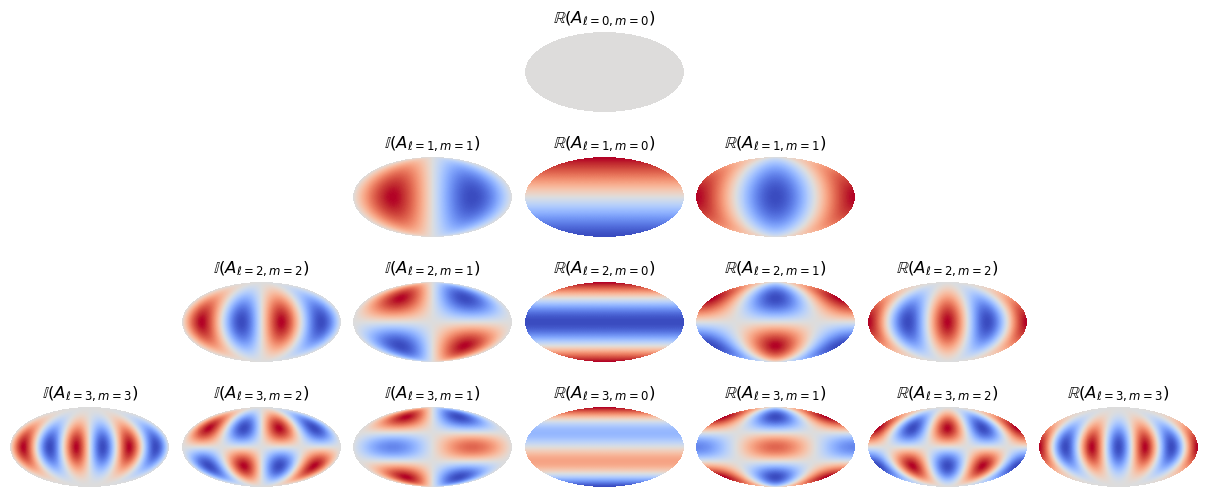

In [2]:
import healpy as hp
import matplotlib.pyplot as plt

lmax=3
level = 8
nside=2**level
#compute Alm 
#get the l and m availble for l<=lmax
l,m=hp.Alm.getlm(lmax=lmax)

#count the number of alm map (1 for m=0 and 2 for m>0)
n_alm=(m==0).sum()+2*(m>0).sum()
function=np.zeros([n_alm,12*nside**2])

alm=np.zeros([l.shape[0]],dtype='complex')

i=0

#array to store the l and m values of the A_lm
l_func=np.zeros(n_alm,dtype='int')
m_func=np.zeros(n_alm,dtype='int')
is_real_func=np.zeros(n_alm,dtype='int')

for k in range(l.shape[0]):
    alm[k]=1.0
    function[i]=hp.reorder(hp.alm2map(alm,nside),r2n=True)
    l_func[i]=l[k]
    m_func[i]=m[k]
    is_real_func[i]=1
    i+=1
    if m[k]>0:
        alm[k]=complex(0,1)
        function[i]=hp.reorder(hp.alm2map(alm,nside),r2n=True)
        l_func[i]=l[k]
        m_func[i]=m[k]
        is_real_func[i]=0
        i+=1
    alm[k]=0.0
lm=3
plt.figure(figsize=(12,5))
for k in range(l_func.shape[0]):
    pos=1+l_func[k]*(2*lm+1)+2*(is_real_func[k]-0.5)*m_func[k]-1+(lm+1)
    if is_real_func[k]==1:
        title='$\mathbb{R}(A_{\ell=%d,m=%d})$'%(l_func[k],m_func[k])
    else:
        title='$\mathbb{I}(A_{\ell=%d,m=%d})$'%(l_func[k],m_func[k])
    if l_func[k]<=lm:
        hp.mollview(function[k],nest=True,hold=False,sub=(lm+1,2*lm+1,pos)
                    ,title=title,cbar=False,cmap='coolwarm')

In [3]:
level = 8
cell_ids = np.arange(12 * 4**level)
grid_info = {"grid_name": "healpix", "level": level, "indexing_scheme": "nested"}

ds = (
    xr.Dataset(coords={"cell_ids": ("cells", cell_ids, grid_info)})
    .pipe(xdggs.decode)
    .pipe(lambda ds: ds.merge(ds.dggs.cell_centers()))
    .assign(
        data=lambda ds: np.cos(6 * np.radians(ds["latitude"]))
        * np.sin(6 * np.radians(ds["longitude"]))
        #data=function[k,:]
    )
)
SH_L3_M2=xr.DataArray(
    function[13,:], 
    dims=("cells"), 
    coords={"cell_ids": ("cells", cell_ids, grid_info)})
ds['SH_L3_M2']=SH_L3_M2
ds

<xarray.Dataset> Size: 31MB
Dimensions:    (cells: 786432)
Coordinates:
  * cell_ids   (cells) int64 6MB 0 1 2 3 4 ... 786428 786429 786430 786431
    latitude   (cells) float64 6MB 0.1492 0.2984 0.2984 ... -0.2984 -0.1492
    longitude  (cells) float64 6MB 45.0 45.18 44.82 45.0 ... 315.2 314.8 315.0
Dimensions without coordinates: cells
Data variables:
    data       (cells) float64 6MB -0.9999 -0.9993 -0.9993 ... 0.9993 0.9999
    SH_L3_M2   (cells) float64 6MB -0.005323 -0.01065 ... -0.01065 -0.005323
Indexes:
    cell_ids  HealpixIndex(nside=8, indexing_scheme=nested, rotation=[0.0, 0.0])

### Plotting with xdggs is very simple, just use 'explore' function

In [4]:
ds["SH_L3_M2"].dggs.explore(center=0, cmap="coolwarm", alpha=0.8)

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f5f5658…

## Open a sample DestinE data in hearlpix (saved in zarr format with attributes)

It is straigh forward to open dataset in xarray to use an annotated zarr file.  

Here we have loaded grib file then transformed it to zarr file with following metadata, and assigned coordinate.  

```bash
.assign_coords(
    cell_ids=('value', np.arange(12*4**10 ), 
              {"grid_name":"healpix","level": 10, "indexing_scheme": "nested"}))
```

In [5]:
ds = xr.open_dataset(
    #"https://data-taos.ifremer.fr/DestinE/average_surface_temperature.zarr",
    "DestinE/average_surface_temperature.zarr",
    engine="zarr",
    chunks={},
    consolidated=True,
)
ds

<xarray.Dataset> Size: 4GB
Dimensions:          (oceanModelLayer: 75, cells: 12582912)
Coordinates:
    cell_ids         (cells) int64 101MB dask.array<chunksize=(100000,), meta=np.ndarray>
    latitude         (cells) float64 101MB dask.array<chunksize=(100000,), meta=np.ndarray>
    longitude        (cells) float64 101MB dask.array<chunksize=(100000,), meta=np.ndarray>
  * oceanModelLayer  (oceanModelLayer) float64 600B 1.0 2.0 3.0 ... 74.0 75.0
    step             timedelta64[ns] 8B ...
    time             datetime64[ns] 8B ...
    valid_time       datetime64[ns] 8B ...
Dimensions without coordinates: cells
Data variables:
    avg_thetao       (oceanModelLayer, cells) float32 4GB dask.array<chunksize=(10, 100000), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-06-03T13:52 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [6]:
data=(ds["avg_thetao"]
 .isel(oceanModelLayer=1)               
 .pint.quantify().pint.to({"avg_thetao": "degC"}).pint.dequantify()
 .pipe(xdggs.decode)
 .compute()
)
data

<xarray.DataArray 'avg_thetao' (cells: 12582912)> Size: 50MB
array([27.385376, 27.390259, 27.359985, ..., 28.333618, 28.351196,
       28.343384], dtype=float32)
Coordinates:
  * cell_ids         (cells) int64 101MB 0 1 2 3 ... 12582909 12582910 12582911
    latitude         (cells) float64 101MB 0.0373 0.0746 ... -0.0746 -0.0373
    longitude        (cells) float64 101MB 45.0 45.04 44.96 ... 315.0 315.0
    oceanModelLayer  float64 8B 2.0
    step             timedelta64[ns] 8B 1 days
    time             datetime64[ns] 8B 2023-01-01
    valid_time       datetime64[ns] 8B 2023-01-02
Dimensions without coordinates: cells
Indexes:
    cell_ids  HealpixIndex(nside=10, indexing_scheme=nested, rotation=[0.0, 0.0])
Attributes: (12/18)
    GRIB_NV:                         0
    GRIB_cfName:                     unknown
    GRIB_cfVarName:                  avg_thetao
    GRIB_dataType:                   fc
    GRIB_gridDefinitionDescription:  150
    GRIB_gridType:                   healpix
    ...                              ...
    GRIB_stepUnits:                  1
    GRIB_typeOfLevel:                oceanModelLayer
    GRIB_units:                      K
    long_name:                       Time-mean sea water potential temperature
    standard_name:                   unknown
    units:                           degree_Celsius

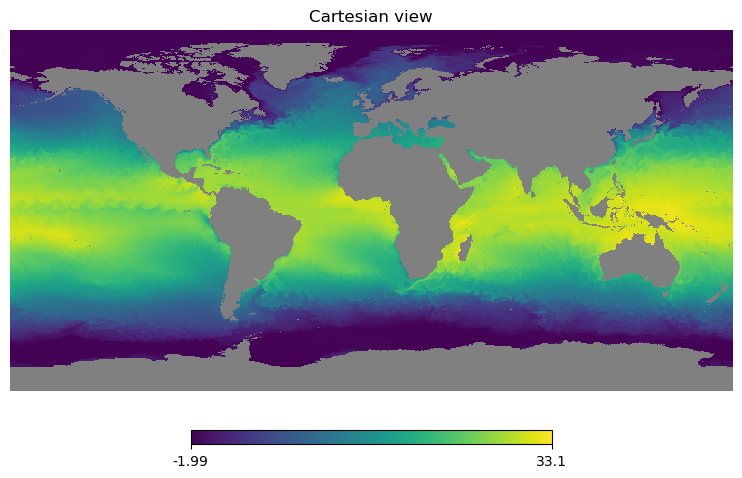

In [7]:
hp.cartview(data.data,nest=True,cmap='viridis',flip='geo')

In [8]:
data.dggs.explore(center=0, cmap="viridis", alpha=0.5)

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f5f3d9e…

### With XDGGS, one can select points of data not only from cell_ids from DGGS, but also from latitude and longitude.

In [10]:
lon = np.arange(48, 49.5, 0.01)
lat = np.arange(354, 355, 0.01)
full_lat = np.repeat(lat, len(lon))
full_lon = np.tile(lon, len(lat))

(
 data.dggs.sel_latlon(longitude=full_lon, latitude=full_lat)
).dggs.explore(center=0, cmap="viridis", alpha=0.8)

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f5f3c05…

## Open a EERIE Cloud  data in hearlpix, saved in zarr format from DKRZ.

NextGems project provide their data set in healpix in zarr format. 
Deatiled description of EERIE Cloud can be found here
https://easy.gems.dkrz.de/simulations/EERIE/eerie_data-access_online.html

After opening we need to assigne coordinate and meta data defining the grid system.    



In [11]:
ds = xr.open_dataset(
    "https://eerie.cloud.dkrz.de/datasets/nextgems.IFS_9-FESOM_5-production.2D_hourly_healpix512/zarr",
    engine="zarr",
    chunks={},
    consolidated=True,
)
ds

<xarray.Dataset> Size: 383TB
Dimensions:  (time: 262537, value: 3145728)
Coordinates:
    lat      (value) float64 25MB dask.array<chunksize=(3145728,), meta=np.ndarray>
    lon      (value) float64 25MB dask.array<chunksize=(3145728,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2MB 2020-01-20 ... 2050-01-01
Dimensions without coordinates: value
Data variables: (12/58)
    10si     (time, value) float64 7TB dask.array<chunksize=(3, 3145728), meta=np.ndarray>
    10u      (time, value) float64 7TB dask.array<chunksize=(3, 3145728), meta=np.ndarray>
    10v      (time, value) float64 7TB dask.array<chunksize=(3, 3145728), meta=np.ndarray>
    2d       (time, value) float64 7TB dask.array<chunksize=(3, 3145728), meta=np.ndarray>
    2t       (time, value) float64 7TB dask.array<chunksize=(3, 3145728), meta=np.ndarray>
    blh      (time, value) float64 7TB dask.array<chunksize=(3, 3145728), meta=np.ndarray>
    ...       ...
    tp       (time, value) float64 7TB dask.array<chunksize=(3, 3145728), meta=np.ndarray>
    tprate   (time, value) float64 7TB dask.array<chunksize=(3, 3145728), meta=np.ndarray>
    tsr      (time, value) float64 7TB dask.array<chunksize=(3, 3145728), meta=np.ndarray>
    tsrc     (time, value) float64 7TB dask.array<chunksize=(3, 3145728), meta=np.ndarray>
    ttr      (time, value) float64 7TB dask.array<chunksize=(3, 3145728), meta=np.ndarray>
    ttrc     (time, value) float64 7TB dask.array<chunksize=(3, 3145728), meta=np.ndarray>
Attributes: (12/13)
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...
    title:              nextgems.IFS_9-FESOM_5-production.2D_hourly_healpix512
    ...                 ...
    time_min:           2020-01-20T00:00:00.000000000
    time_max:           2050-01-01T00:00:00.000000000
    creation_date:      2024-10-15T00:01:47Z
    authors:            Wieners, Karl-Hermann (MPIMet), Aguridan, Razvan (ECM...
    contact:            Wieners, Karl-Hermann (MPIMet), Rackow, Thomas (ECMWF)
    license:            Creative Commons Attribution 4.0 International (CC BY...

In [12]:
ds = ds.assign_coords(
    cell_ids=(
        "value",
        np.arange(12 * 4**9),
        {"grid_name": "healpix", "level": 9, "indexing_scheme": "nested"},
    )
)

In [13]:
data = ds["msl"].isel(time=1000).compute().pipe(xdggs.decode)
data

<xarray.DataArray 'msl' (value: 3145728)> Size: 25MB
array([100984.51660156, 100988.79394531, 100979.44824219, ...,
       101204.87207031, 101202.56152344, 101200.22753906])
Coordinates:
    lat       (value) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon       (value) float64 25MB 45.0 45.09 44.91 45.0 ... 315.1 314.9 315.0
    time      datetime64[ns] 8B 2020-03-01T16:00:00
  * cell_ids  (value) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
Dimensions without coordinates: value
Indexes:
    cell_ids  HealpixIndex(nside=9, indexing_scheme=nested, rotation=[0.0, 0.0])
Attributes: (12/15)
    paramId:                    151
    dataType:                   fc
    numberOfPoints:             3145728
    typeOfLevel:                meanSea
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       Mean sea level pressure
    cfName:                     air_pressure_at_mean_sea_level
    cfVarName:                  msl
    missingValue:               9999
    NV:                         0
    gridDefinitionDescription:  150

In [14]:
data.dggs.explore(center=0, cmap="viridis", alpha=0.8)

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f5ec807…

### Selecting region to plot
#### Selection using healpix cell_ids

In [15]:
data.sel(cell_ids=slice(0, 1000)).dggs.explore(cmap="viridis", alpha=0.8)  # center=0,

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f5ec324…

#### Selection using latitude and longitude

In [16]:
(
    data.dggs.sel_latlon(latitude=0, longitude=48)
    .expand_dims("cell_ids")
    .pipe(xdggs.decode)
).dggs.explore(center=0, cmap="viridis", alpha=0.8)

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f5f3da5…

In [17]:
(data.dggs.sel_latlon(longitude=[48, 47, 46], latitude=[-5, -5.3, -5.5])).dggs.explore(
    center=0, cmap="viridis", alpha=0.8
)

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f5ec3c5…

In [18]:
lon = np.arange(48.5, 49, 0.01)
lat = np.arange(355, 355.5, 0.01)
full_lat = np.repeat(lat, len(lon))
full_lon = np.tile(lon, len(lat))

(
 data.dggs.sel_latlon(longitude=full_lon, latitude=full_lat)
).dggs.explore(center=0, cmap="viridis", alpha=0.8)

Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f5ec324…

## Current Issue with Testing Different Datasets

It is crucial to define a consistent coordinate 'name' and establish how attributes should be specified in order to test different data sources without having to re-define the coordinate name for each dataset. In **XDGGS**, we follow the convention below:

```python
.assign_coords(
    cell_ids=('value', np.arange(12*4**10), 
              {"grid_name": "healpix", "level": 10, "indexing_scheme": "nested"}))
```

## Whats next

Currently, selecting data by latitude and longitude must be done on a point-by-point basis. However, the conventional approach for users to select a region of interest is still a bounding box (bbox) using latitude and longitude. Therefore, enabling this functionality is a priority to streamline data selection.